# Проект: Прогноз оттока клиентов фитнес-клуба

### Описание данных:

- 'Churn' — факт оттока в текущем месяце;

##### Данные клиента за предыдущий до проверки факта оттока месяц:
- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

##### Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

## <span style="color:blue"> Шаг 1: Чтение данных и сводная информация <span>

In [2]:
df=pd.read_csv('/datasets/gym_churn.csv')

In [3]:
df.sample(5)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
3439,1,1,0,0,1,1,1,25,169.903506,1.0,0,1.626956,0.660728,1
767,1,1,0,0,1,6,1,32,134.410628,6.0,3,3.829346,3.687758,0
948,0,0,0,0,1,1,1,32,70.067825,1.0,2,0.472623,0.368360,0
358,0,1,0,0,1,1,0,27,179.622549,1.0,3,2.213064,1.087306,1
803,1,0,0,0,1,1,1,23,125.351341,1.0,1,1.570469,1.293557,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


In [5]:
# проверяю пропуски
df.isna().sum()

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

In [6]:
# проверяю дубликаты
df.duplicated().sum()

0

In [7]:
# привожу название столбцов к нижнему регистру
df.columns = df.columns.str.lower()
df.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

In [8]:
df['contract_period'].value_counts()

1     2207
12     960
6      833
Name: contract_period, dtype: int64

Просто я тут заметила, что в описании проекта написано что есть абонементы длительностью месяц, 3 месяца, 6 месяцев, год. Но на самом деле 3 месячных абонементов нет в данных.

## <span style="color:blue"> Шаг 2: Исследовательский анализ данных (EDA) <span>

In [9]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Выводы:
- Нет отклонений в бинарных признаках (пол, район, факт привлечения друга, факт посещения, факт оттока)  - везде максимальное значение равно 1;
- мужчин и женщин примерно поровну;
- так же как и сотрудников партнеров и обычных посетителей поровну;
- средний возрат 29 лет, максимальный возраст 41 (Видимо выборка - целевая аудитория клуба, хотя вот пенсионеры все чаще тоже посещают фитнесы. Я как в субботу утром не приду, на всех дорожках в бассейне одни бабули плавают.)

Мои первые предположения такие (если не брать в рачсет среднюю посещаемость, а рассматривать другие признаки):
- вероятность оттока будет выше у людей, которые не проживают или работают в районе фитнес-клуба, тк ехать далеко лень;
- вероятность оттока будет выше у людей, которые пришли не по промокоду от друга, тк с другом ходить веселее и можно мотивировать друг друга. 

In [10]:
df.groupby('churn').agg('mean').T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


По среднему значению оттока сильно выделяются признаки:

1) период контракта (отток выше у тех, кто заключал договор на месяц);

2) время с момента первого обращения в фитнес (клиенты, которые посещали меньше месяца чаще уходят).

### Графики зависимости оттока и бинарных признаков, а также распределение бинарных признаков

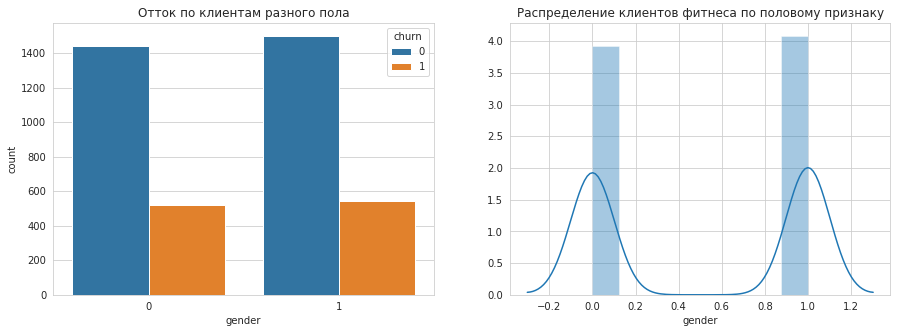

In [11]:
#отток и пол
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(1 , 2, figsize = (15, 5))

ax1.set(title='Отток по клиентам разного пола')
ax2.set(title='Распределение клиентов фитнеса по половому признаку')

sns.countplot(x = df['gender'], hue='churn', data=df, ax=ax1)
sns.distplot(df['gender'], ax=ax2)

plt.show()

И распределение и отток в разрезе пола примерно одинаковый.

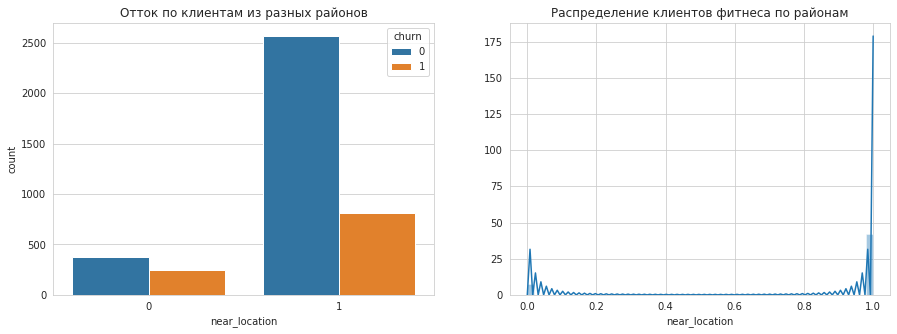

In [12]:
# отток и район
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(1 , 2, figsize = (15, 5))

ax1.set(title='Отток по клиентам из разных районов')
ax2.set(title='Распределение клиентов фитнеса по районам')

sns.countplot(x = df['near_location'], hue='churn', data=df, ax=ax1)
sns.distplot(df['near_location'], ax=ax2)
plt.show()

Если посмотреть на соотношения в столбцах, можно заметить, что количество отвалившихся клиентов, живущих не в районе фитнеса более чем в два раза превышает оставшихся. А в соседнем столбце, клиенты проживающие в том же районе где и фитнес, соотносятся скорее как 1 к 3 в пользу посещающих фитнес регулярно.

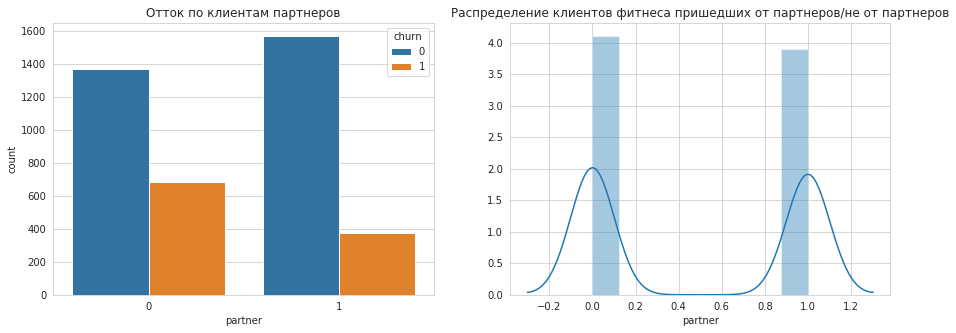

In [13]:
# отток и партнеры
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(1 , 2, figsize = (15, 5))

ax1.set(title='Отток по клиентам партнеров')
ax2.set(title='Распределение клиентов фитнеса пришедших от партнеров/не от партнеров')

sns.countplot(x = df['partner'], hue='churn', data=df, ax=ax1)
sns.distplot(df['partner'], ax=ax2)
plt.show()

Отток клиетов от партнеров меньше.

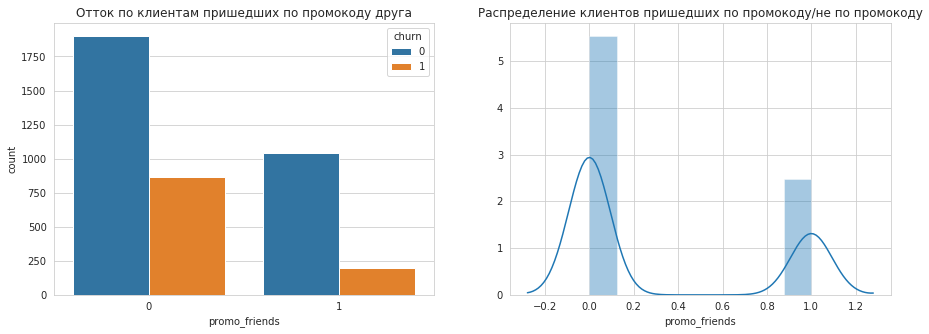

In [14]:
# отток и промо друга
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(1 , 2, figsize = (15, 5))

ax1.set(title='Отток по клиентам пришедших по промокоду друга')
ax2.set(title='Распределение клиентов пришедших по промокоду/не по промокоду')

sns.countplot(x = df['promo_friends'], hue='churn', data=df, ax=ax1)
sns.distplot(df['promo_friends'], ax=ax2)
plt.show()

Количество клиентов, которые пришли не по промокоду друга больше. Но отток меньше у тех, кто пришел с другом.

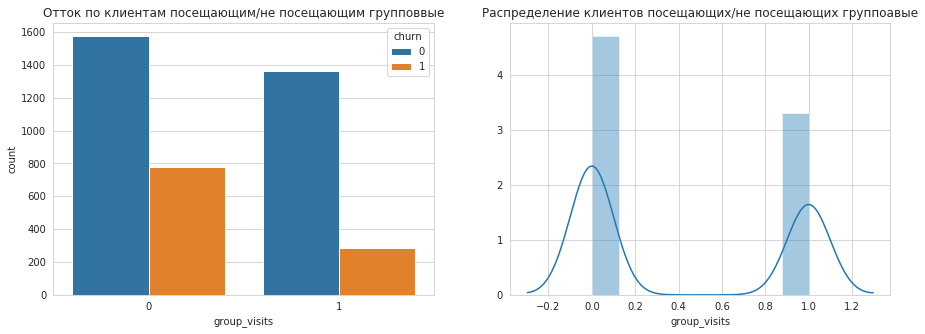

In [15]:
# отток и групповые занятия
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(1 , 2, figsize = (15, 5))

ax1.set(title='Отток по клиентам посещающим/не посещающим групповвые')
ax2.set(title='Распределение клиентов посещающих/не посещающих группоавые')

sns.countplot(x = df['group_visits'], hue='churn', data=df, ax=ax1)
sns.distplot(df['group_visits'], ax=ax2)
plt.show()

Отток меньше у тех, кто посещал групповые. Я думаю, что психологически легче мотивировать себя ходить на фитнес по расписанию. Выбрал групповое занятие в определенное время и ходишь каждую неделю.

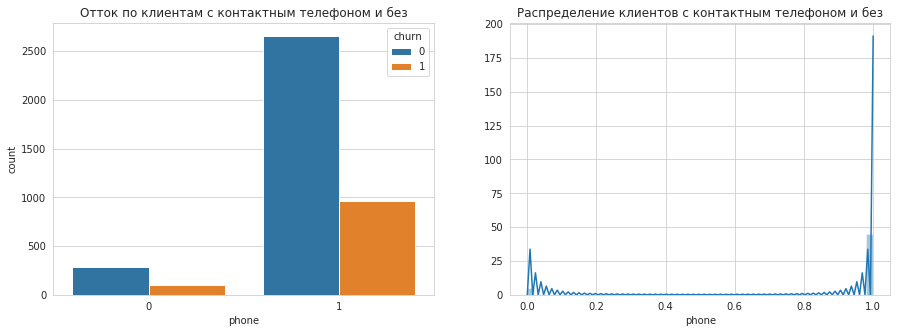

In [16]:
# отток и контактный телефон
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(1 , 2, figsize = (15, 5))

ax1.set(title='Отток по клиентам с контактным телефоном и без')
ax2.set(title='Распределение клиентов с контактным телефоном и без')

sns.countplot(x = df['phone'], hue='churn', data=df, ax=ax1)
sns.distplot(df['phone'], ax=ax2)
plt.show()

Для меня странно, что вообще есть клиенты без контактного телефона, тк при заключении договора его просят указать. 

### Графики зависимости оттока и небинарных признаков, а также распределение небинарных признаков

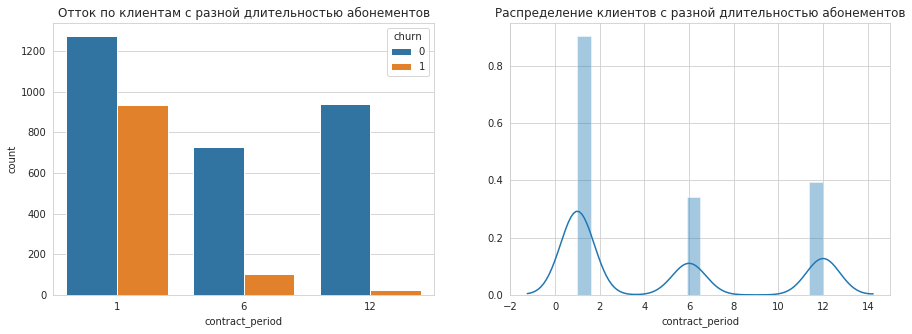

In [17]:
# отток и период договора
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(1 , 2, figsize = (15, 5))

ax1.set(title='Отток по клиентам с разной длительностью абонементов')
ax2.set(title='Распределение клиентов с разной длительностью абонементов')

sns.countplot(x = df['contract_period'], hue='churn', data=df, ax=ax1)
sns.distplot(df['contract_period'], ax=ax2)
plt.show()

Очень выделяется столбец с периодом в 1 месяц, большой отток. Но тут еще может быть такой вариант: фитнес предлагает по акции 1 месяц бесплатно и любители халявы занимаются 1 месяц и дальше не продливают договор. Я уже давно не видела таких договоров на 1 месяц, в основном предлагают ходить либо по занятиям вне зависимости от срока, либо 3, 6, 12 месяцев абонемент.

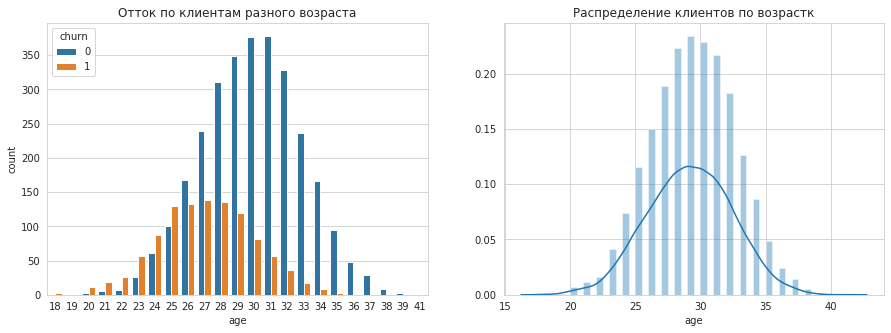

In [18]:
# отток и возраст
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(1 , 2, figsize = (15, 5))

ax1.set(title='Отток по клиентам разного возраста')
ax2.set(title='Распределение клиентов по возрастк')

sns.countplot(x = df['age'], hue='churn', data=df, ax=ax1)
sns.distplot(df['age'], ax=ax2)
plt.show()

У молодых отток больше (до 26 лет), мне кажется, они чаще переезжают, пока не обзавелись собственным жильем и меняют работу. Да и финансово фитнес доступен не для всех, поэтому у них отток больше. Хотя у некоторых фитнесов есть студенческие абонементы.

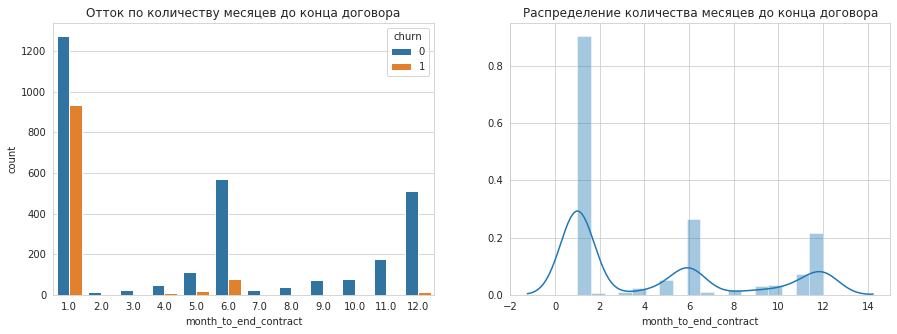

In [19]:
# отток и количество месяцев до конца договора
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(1 , 2, figsize = (15, 5))

ax1.set(title='Отток по количеству месяцев до конца договора')
ax2.set(title='Распределение количества месяцев до конца договора')

sns.countplot(x = df['month_to_end_contract'], hue='churn', data=df, ax=ax1)
sns.distplot(df['month_to_end_contract'], ax=ax2)
plt.show()

Мне кажется это не очень показательный признак. У нас получается, что в столбец со значением "1", попадают все клиенты у которых длительность абонемента 1 месяц, и те, кто занимался например 11 месяцев и у них остался 1 до конца годового абонемента.

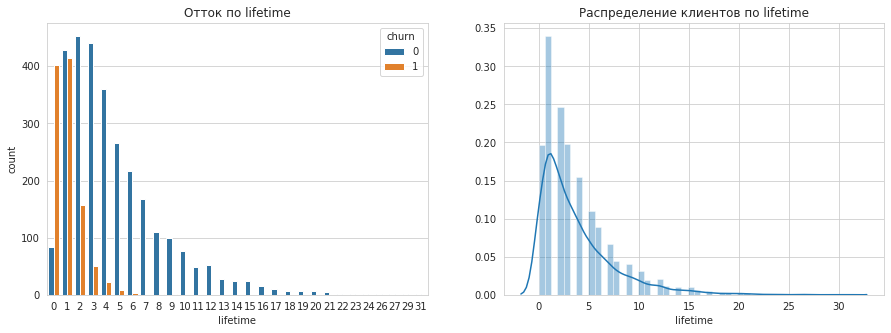

In [20]:
# отток и время с момента покупки первого абонимента
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(1 , 2, figsize = (15, 5))

ax1.set(title='Отток по lifetime')
ax2.set(title='Распределение клиентов по lifetime')

sns.countplot(x = df['lifetime'], hue='churn', data=df, ax=ax1)
sns.distplot(df['lifetime'], ax=ax2)
plt.show()

В первые месяцы очень большой отток. Купили абонемент, попробовали, поняли что спорт это не их и ушли)

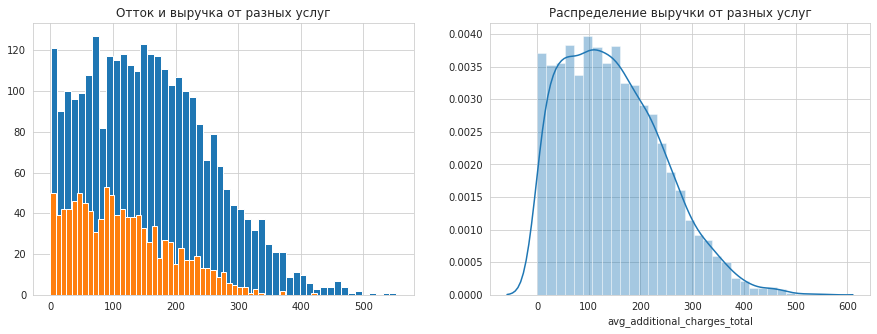

In [21]:
# отток и суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон
t=df.groupby(['churn'])['avg_additional_charges_total']

sns.set_style("whitegrid")

fig, (ax1, ax2) = plt.subplots(1 , 2, figsize = (15, 5))

ax1.set(title='Отток и выручка от разных услуг')
ax2.set(title='Распределение выручки от разных услуг')

t.hist(bins=50, ax=ax1)
sns.distplot(df['avg_additional_charges_total'], ax=ax2)
plt.show()

Тут как будто нет какой то явной зависимости типо : тратят больше - уходят реже.

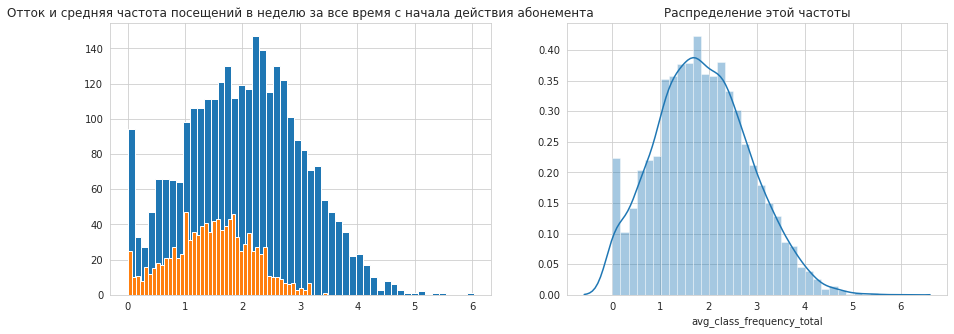

In [22]:
# отток и средняя частота посещений в неделю за все время с начала действия абонемента
t=df.groupby(['churn'])['avg_class_frequency_total']

sns.set_style("whitegrid")

fig, (ax1, ax2) = plt.subplots(1 , 2, figsize = (15, 5))

ax1.set(title='Отток и средняя частота посещений в неделю за все время с начала действия абонемента')
ax2.set(title='Распределение этой частоты')

t.hist(bins=50, ax=ax1)
sns.distplot(df['avg_class_frequency_total'], ax=ax2)
plt.show()

Средняя частота посещений групповых в неделю ниже у отточных. (1-2 раза в неделю)

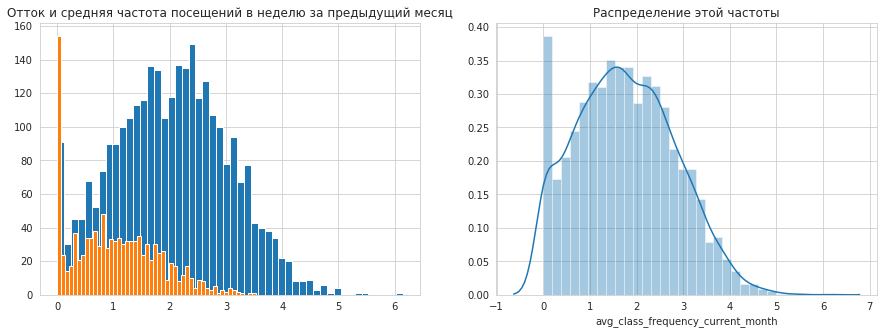

In [23]:
# отток и средняя частота посещений в неделю за предыдущий месяц
t=df.groupby(['churn'])['avg_class_frequency_current_month']

sns.set_style("whitegrid")

fig, (ax1, ax2) = plt.subplots(1 , 2, figsize = (15, 5))

ax1.set(title='Отток и средняя частота посещений в неделю за предыдущий месяц')
ax2.set(title='Распределение этой частоты')

t.hist(bins=50, ax=ax1)
sns.distplot(df['avg_class_frequency_current_month'], ax=ax2)
plt.show()

Если в течении месяца предыдущего не ходил, скорее всего клиент покинул фитнес.

### Матрица корреляций 

In [24]:
cm = df.corr()
cm

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
near_location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


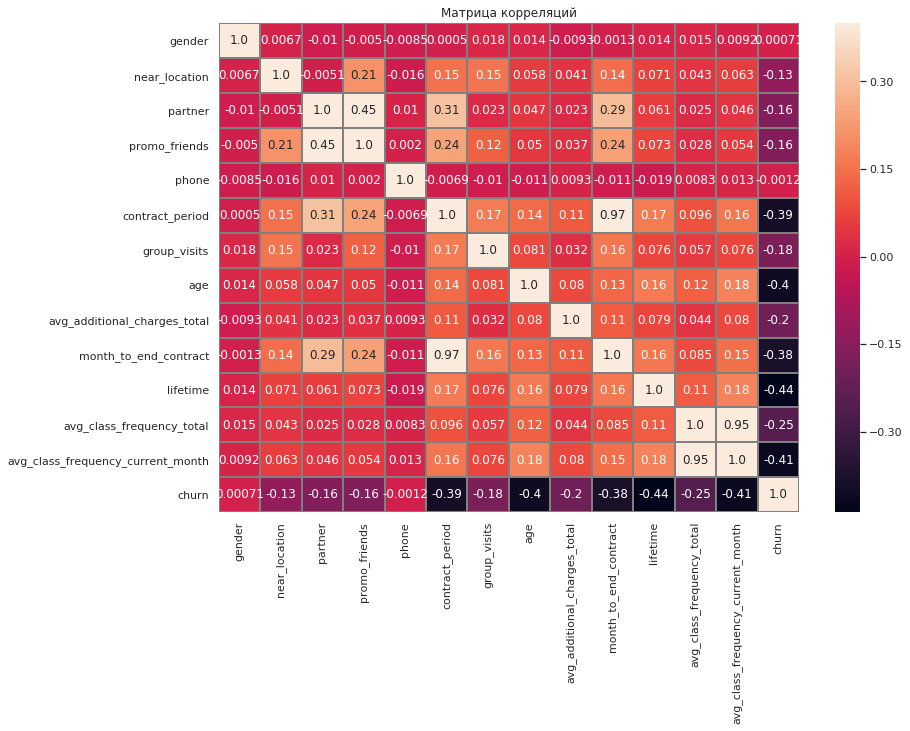

In [25]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Матрица корреляций')
sns.heatmap(cm, annot = True, fmt='.2', linewidths=1, linecolor='gray', vmax=.4)
plt.show()

Есть сильно кореллирующие признаки:

1) mohtn_to_end_contract и contract_period

2) avg_class_frequency_current_month и avg_class_frequency_total

3) promo_friends и partner

## <span style="color:blue"> Шаг 3: Модель прогнозирования оттока клиентов <span>

Убираю коррелирующие признаки. 
Период контракта оставляю, мне кажется это важным признаком. А месяцы до конца договора, убираю.
Оставляю среднюю частоту посещения за предыдущий месяц, так как я предположила ранее, что клиент не ходивший месяц до, будет продолжать не посещать фитнес.
Промо друзей и партнер коррелирует в меньшей степени, чем предыдущие признаки. Тем не менее, если партнерская компания решит сменить фитнес клуб, то скорее всего все партнерские сотрудниик сменят клуб. В оттоке будет резкий всплеск. При этом промокод от друга, скорее всего включает в себя партнерских клиентов, так как коллеги часто ходят на фитнес вместе после работы. Поэтому оставляю промокоды.

In [26]:
df_ml= df.drop(['month_to_end_contract', 'avg_class_frequency_total', 'partner'], axis=1).copy()

In [27]:
#разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df_ml.drop('churn', axis = 1)
y = df_ml['churn']

In [28]:
#разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

In [29]:
# стандартизация
scaler = StandardScaler()
#обучаем scaler и одновременно трансформируем матрицу для обучающей выборки
X_train_st = scaler.fit_transform(X_train)
#применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

### Логистическая регрессия

In [30]:
lr_ml = LogisticRegression(random_state = 0)

In [31]:
# обучаем модель линейной регрессии
lr_ml.fit(X_train_st, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
# прогнозы
lr_predictions = lr_ml.predict(X_test_st)
lr_probabilities = lr_ml.predict_proba(X_test_st)[:,1]

### Случайный лес

In [33]:
rf_ml = RandomForestClassifier(n_estimators = 100, random_state=0)

In [34]:
# обучаем модель случайного леса
rf_ml.fit(X_train_st, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [35]:
# прогнозы
rf_predictions = rf_ml.predict(X_test_st)
rf_probabilities = rf_ml.predict_proba(X_test_st)[:,1]

### Сравнение метрик 

In [36]:
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, y_proba, title = 'Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

In [37]:
# метрики логистической регрессии
print_all_metrics(y_test, lr_predictions, lr_probabilities , title='Метрики для модели логистической регрессии:')

Метрики для модели логистической регрессии:
	Accuracy: 0.90
	Precision: 0.79
	Recall: 0.82
	F1: 0.80
	ROC_AUC: 0.96


In [38]:
# метрики случайного леса 
print_all_metrics(y_test, rf_predictions, rf_probabilities, title = 'Метрики для модели случайного леса:')

Метрики для модели случайного леса:
	Accuracy: 0.89
	Precision: 0.80
	Recall: 0.76
	F1: 0.78
	ROC_AUC: 0.95


Выводы по метрикам:

В целом, метрики практически одинаковые. Чуть лучше выглядят метрики линейной регрессии. 


## <span style="color:blue"> Шаг 4: Кластеризация клиентов <span>

In [39]:
X = df_ml.drop('churn', axis = 1)

In [40]:
# стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [41]:
# матрица расстояний
linked = linkage(X_sc, method = 'ward')

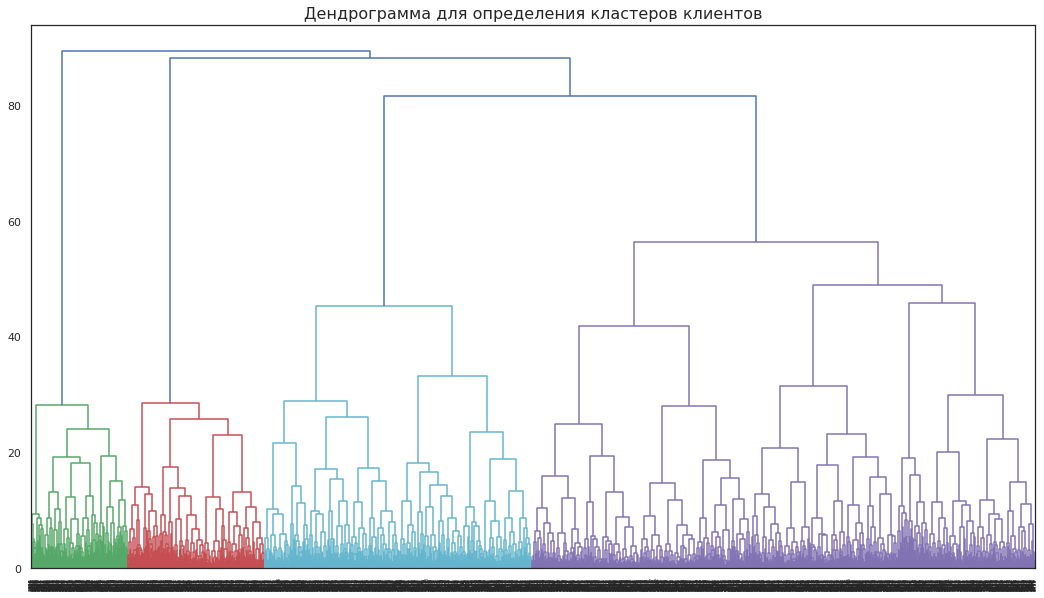

In [42]:
# дендрограмма
plt.figure(figsize=(18, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма для определения кластеров клиентов', fontsize=16)
plt.show()

Вот тут не очень поняла почему все таки на 5 кластеров делим, по дедрограмме кажется их 4.

In [43]:
# задаём модель k_means с числом кластеров 5
km = KMeans(n_clusters = 5, random_state=0)
# прогнозируем кластеры для наблюдений
labels = km.fit_predict(X_sc)

In [44]:
df_ml['cluster'] = labels

In [45]:
df_ml.groupby('cluster').mean().T

cluster,0,1,2,3,4
gender,0.476689,0.541905,0.523316,0.513089,0.500000
near_location,1.000000,0.996190,0.862694,0.995812,0.000000
promo_friends,0.111323,0.000000,0.305699,1.000000,0.078853
phone,1.000000,1.000000,0.000000,1.000000,1.000000
contract_period,2.066603,5.941905,4.777202,7.119372,2.994624
group_visits,0.248335,0.540952,0.427461,0.549738,0.232975
age,27.335871,30.668571,29.297927,29.835602,28.679211
avg_additional_charges_total,118.571471,173.699658,144.208179,155.592797,137.125763
lifetime,1.824929,5.209524,3.940415,4.534031,2.974910
avg_class_frequency_current_month,1.112827,2.318508,1.723967,1.997417,1.597146


Можно заметить, что пол на отток не влияет, во всех кластерах среднее значение пола примерно 0,5. В кластере "1" самое маленькое среднее значение оттока, при этом самое большое среднее значение времени жизни и самая высокая частота посещения групповых за предыдущий месяц, то есть клиенты - не новички и постоянно посещающие занятия не уходят.

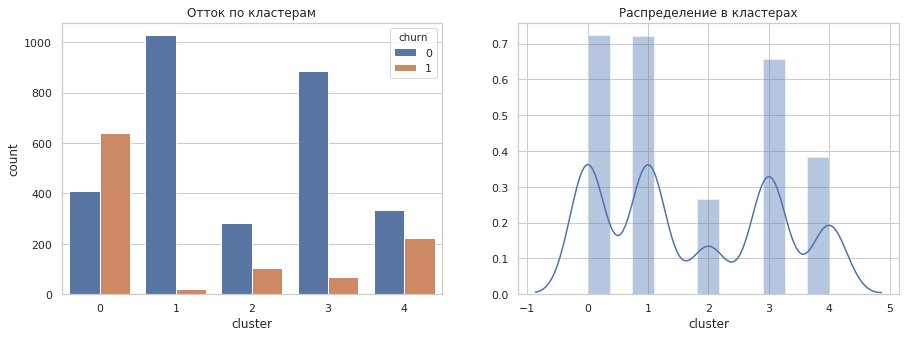

In [46]:
#отток по кластерам
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(1 , 2, figsize = (15, 5))

ax1.set(title='Отток по кластерам')
ax2.set(title='Распределение в кластерах')

sns.countplot(x = df_ml['cluster'], hue='churn', data=df, ax=ax1)
sns.distplot(df_ml['cluster'], ax=ax2)

plt.show()

Кластер "0" очень выделяется по оттоку клиентов. Кластер "1" самый хороший. По количеству клиентов эти кластеры практически идентичны, но отточность в них прямопротивоположная. 

### Распределения для кластеров

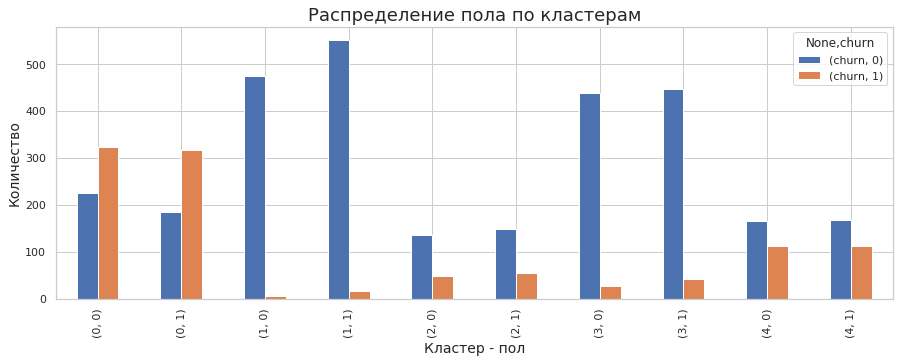

In [47]:
df_ml.pivot_table(index=['cluster', 'gender'], columns='churn', aggfunc=({'churn':'count'})).plot(kind='bar', grid=True, figsize=(15, 5))
plt.title('Распределение пола по кластерам', fontsize=18)
plt.ylabel('Количество', fontsize=14)
plt.xlabel("Кластер - пол", fontsize=14)
plt.show()

Тут сразу видно что вне зависимости от пола кластер "0" опережает всех по оттоку, в кластере "4" тоже высокий отток. А вот кластеры "1" и "3" имеют минимальный отток.

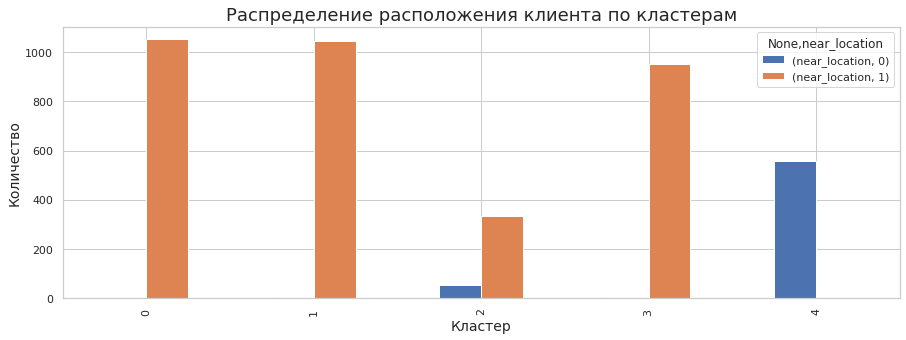

In [48]:
df_ml.pivot_table(index='cluster', columns='near_location', aggfunc=({'near_location':'count'})).plot(kind='bar', grid=True, figsize=(15, 5))
plt.title('Распределение расположения клиента по кластерам', fontsize=18)
plt.ylabel('Количество', fontsize=14)
plt.xlabel("Кластер", fontsize=14)
plt.show()

В кластер "4" попали почти все клиенты из других районов.

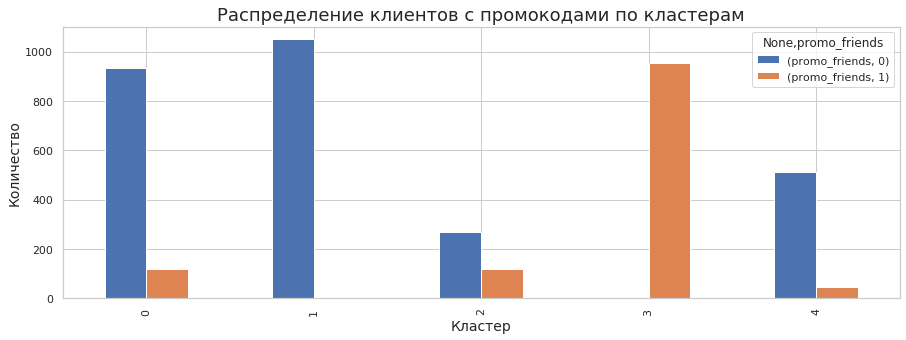

In [49]:
df_ml.pivot_table(index='cluster', columns='promo_friends', aggfunc=({'promo_friends':'count'})).plot(kind='bar', grid=True, figsize=(15, 5))
plt.title('Распределение клиентов с промокодами по кластерам', fontsize=18)
plt.ylabel('Количество', fontsize=14)
plt.xlabel("Кластер", fontsize=14)
plt.show()

Кластер "3" наибольший по клиентам с промокодами от друзей.

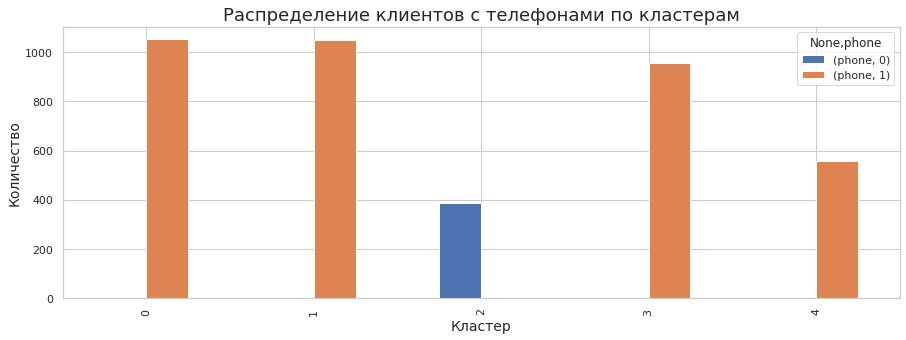

In [50]:
df_ml.pivot_table(index='cluster', columns='phone', aggfunc=({'phone':'count'})).plot(kind='bar', grid=True, figsize=(15, 5))
plt.title('Распределение клиентов с телефонами по кластерам', fontsize=18)
plt.ylabel('Количество', fontsize=14)
plt.xlabel("Кластер", fontsize=14)
plt.show()

Кластер "2" - клиенты без контактного телефона.

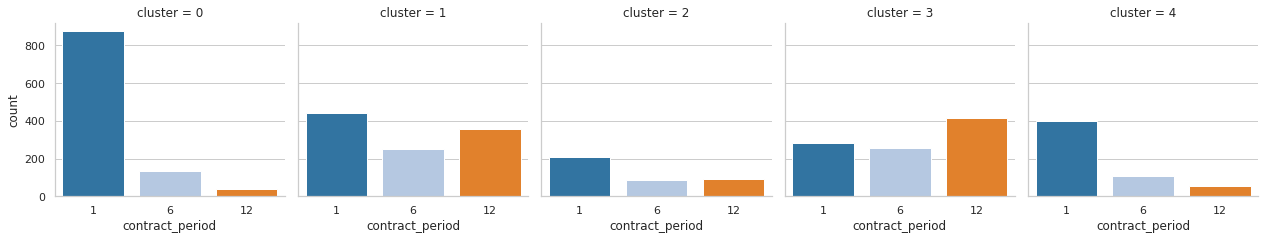

In [51]:
# распределение по периоду контракта

sns.catplot("contract_period", col="cluster", col_wrap=5,
                data=df_ml,
                kind="count", height=3.5,
                palette='tab20')

plt.show()

В кластере "0" много клиентов с контактами на месяц. А в кластерах "1" и "3" много годовых абонементов.

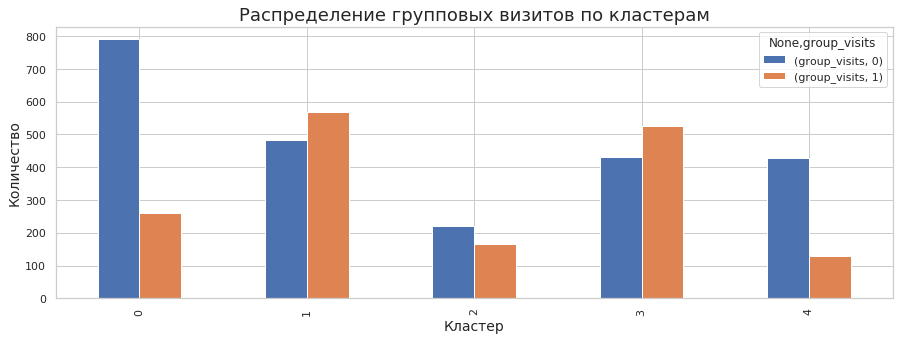

In [52]:
df_ml.pivot_table(index='cluster', columns='group_visits', aggfunc=({'group_visits':'count'})).plot(kind='bar', grid=True, figsize=(15, 5))
plt.title('Распределение групповых визитов по кластерам', fontsize=18)
plt.ylabel('Количество', fontsize=14)
plt.xlabel("Кластер", fontsize=14)
plt.show()

В кластерах "1" и "3" клиентов с фактом посещения групповых занятий больше.

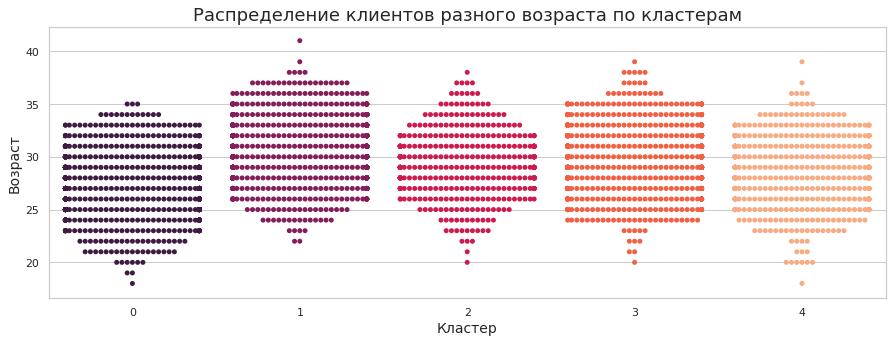

In [53]:
fig, ax=plt.subplots(figsize=(15, 5))
sns.swarmplot(x='cluster', y="age", data=df_ml, palette='rocket')
plt.title('Распределение клиентов разного возраста по кластерам', fontsize=18)
plt.ylabel('Возраст', fontsize=14)
plt.xlabel("Кластер", fontsize=14)
plt.show()

В кластере "0" более молодые клиенты, максимальный возраст - 35 лет.

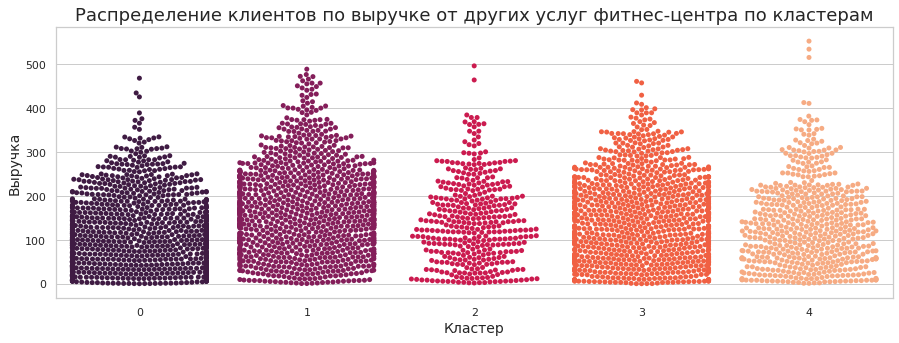

In [54]:
fig, ax=plt.subplots(figsize=(15, 5))
sns.swarmplot(x='cluster', y="avg_additional_charges_total", data=df_ml, palette='rocket')
plt.title('Распределение клиентов по выручке от других услуг фитнес-центра по кластерам', fontsize=18)
plt.ylabel('Выручка', fontsize=14)
plt.xlabel("Кластер", fontsize=14)
plt.show()

Кластер "2" включает меньшее количство клиентов, которые тратят деньги на услуги фитнеса. 

<Figure size 1080x720 with 0 Axes>

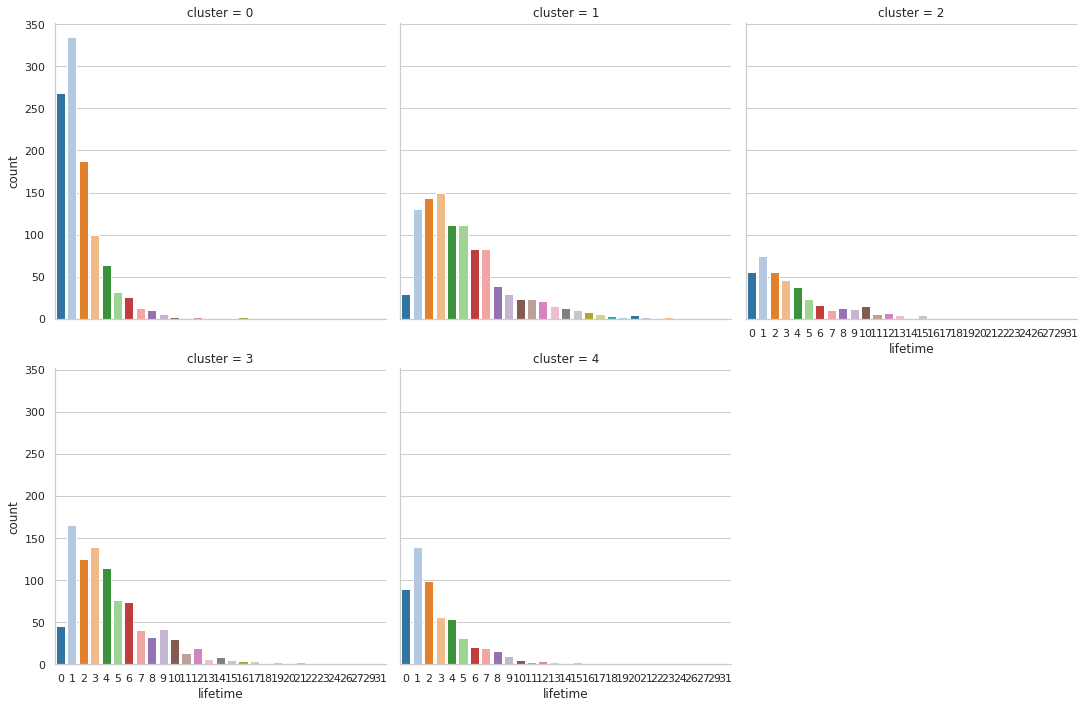

In [55]:
plt.figure(figsize=(15,10))

sns.catplot("lifetime", col="cluster", col_wrap=3,
                data=df_ml,
                kind="count", height=5,
                palette='tab20')

plt.show()

Кластер "0" включает в себя большую часть новых клиентов, которые занимаются месяц или меньше.

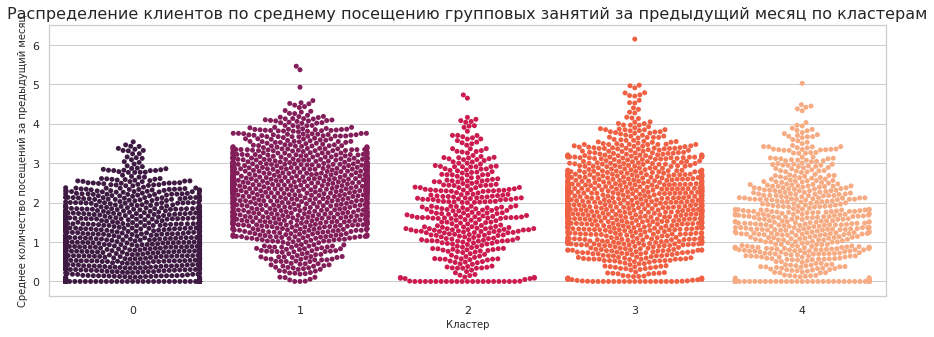

In [56]:
fig, ax=plt.subplots(figsize=(15, 5))
sns.swarmplot(x='cluster', y="avg_class_frequency_current_month", data=df_ml, palette='rocket')
plt.title('Распределение клиентов по среднему посещению групповых занятий за предыдущий месяц по кластерам', fontsize=16)
plt.ylabel('Среднее количество посещений за предыдущий месяц', fontsize=10)
plt.xlabel("Кластер", fontsize=10)
plt.show()

В кластере "0" основная масса клиентов посещает от 0 до 2 раз в месяц, максимальное значение в районе 3,5. То есть клиенты посещают фитнес даже меньше чем раз в неделю. 

#### Доля оттока по кластерам

In [57]:
df_ml.groupby('cluster')['churn'].mean().round(2)

cluster
0    0.61
1    0.02
2    0.27
3    0.07
4    0.40
Name: churn, dtype: float64

Доля оттока в кластере "0" самая большая, также к отточным можно отнести кластер "4". Кластер "1" наименьший по оттоку.

### <span style="color:blue"> Шаг 5: Выводы <span>

1. Данные были стандартизированы, после чего спрогнозированы 2 модели оттока клиентов (с помощью линейной регресии и случайно леса). Метрики моделей очень похожи, метрики линейной регресии чуть лучше.

2. Проведено разделение клиентов на 5 кластеров:

        Пол не влияет на отток клиентов.

   1) Кластер "0" - лидирует по доле оттока (61%)
    - самые молодые клиенты по возрасту и по lifetime
    - не посещают групповые занятия
    - период контаркта 1 месяц
    - живут в районе фитнеса, контактный телефон есть
    - пришли не по промокоду друга
    
    2) Кластер "1" - минимальный по доле оттока (2%)
    - наиболее возрастные клиенты
    - посещали групповые
    - много клиентов с годовым абонеметом
    - живут рядом, есть контактный телефон
    - пришли не по промокоду
    
    3) Кластер "2" - средний отток (27%)
    - маленький по количеству клиентов в нем
    - почти равное посещение/не посещение групповых, чуть больше непосещающих
    - распределение по абониментам почти одинаковое, чуть больше с 1 месяцем
    - небольшое количество клиентов из других районов
    - все клиенты без контактного телефона
    
    4) Кластер "3" - небольшой отток (7%)
    - клиентов с групповыми посещениями немного больше 
    - много годовых абонементов
    - живут рядом, контактный телефон есть
    - все пришли по промокоду друга
    
    5) Кластер "4" - отток большой (40%)
    - много клиентов не посещают групповые
    - много клиентов с абонементом в 1 месяц
    - живут не рядом
    - пришли не по промокоду
    - контактный телефон есть

#### Рекомендации по удержанию клиентов
  
1. Мы выявили, что отток в кластере "0" наибольший, а также в этом кластере много клиентов с периодом контракта в 1 месяц. Есть вероятность, что их не устраивает цена на более длительные абонементы. Если предложить им после месяца занятий купить абонемент по акционной цене (причем увеличивать скидку в зависимости от срока абонемента, например 3 месяца 5%, 6 - 10%, 12 - 15%), возможно они остануться.

2. Кластер "4" включает в себя клиентов, которые живут не рядом с фитнесом. Если фитнес клуб сетевой, я бы предложила клиентам перевести свой абонемент в ближайший для них фитнес. Если не сетевой, и клиент не работает и не живет рядом, маловероятно что он все таки останется. (я бы не осталась, все ценят свое время и не хотят на дорогу тратить много)

3. В кластере "2" средний отток и там клиенты без контактного номера телефона. Если анкета персональных данных на абонемент заполняется клиентом на сайте фитнеса, можно было бы сделать поле с телефоном обязательным к заполнению. Контактный телефон важен, так как можно рассылать акции в смс-оповещениях или звонить и предлагать новые персональные условия.